<a href="https://colab.research.google.com/github/Ghisbe/Alarmas_pictogramas/blob/main/Modelo_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Redes neuronales recurrentes.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
import gdown
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
url = "https://drive.google.com/uc?id=1fs7dmydF11O-rw1xX3ZDZd-7dGew73lu"

In [ ]:
output = 'alertas_lemma.csv'
gdown.download(url, output, quiet=False)

# Leer el archivo CSV en un DataFrame de pandas
alertas = pd.read_csv(output)

Downloading...
From (original): https://drive.google.com/uc?id=1fs7dmydF11O-rw1xX3ZDZd-7dGew73lu
From (redirected): https://drive.google.com/uc?id=1fs7dmydF11O-rw1xX3ZDZd-7dGew73lu&confirm=t&uuid=67a2d96f-5934-4e94-926c-3c8274231271
To: /content/alertas_lemma.csv
100%|██████████| 143M/143M [00:02<00:00, 64.1MB/s]


In [ ]:
alertas.head()

,id,event,description,instruction,urgency,severity,description_token,description_no_stopwords,lemmatized_description
0,5ed30eb3283336e2e7c8a2a8,Dust Storm Warning,the national weather service in phoenix has is...,Motorists should not drive into a dust storm. ...,Expected,Severe,"['the', 'national', 'weather', 'service', 'in'...","['national', 'weather', 'service', 'phoenix', ...","['national', 'weather', 'service', 'phoenix', ..."
1,5e6daf2c023f1930efa590ce,Tropical Storm Warning,what winds thirty to forty kt and seas five t...,Mariners should alter plans to avoid these haz...,Immediate,Severe,"['what', 'winds', 'thirty', 'to', 'forty', 'kt...","['winds', 'thirty', 'forty', 'kt', 'seas', 'fi...","['winds', 'thirty', 'forty', 'kt', 'seas', 'fi..."
2,5e6daf2c023f1930efa590d1,Tropical Storm Warning,what northeast winds twenty-five to thirty-fi...,Mariners should alter plans to avoid these haz...,Immediate,Severe,"['what', 'northeast', 'winds', 'twenty-five', ...","['northeast', 'winds', 'twenty-five', 'thirty-...","['northeast', 'winds', 'twenty-five', 'thirty-..."
3,5ec39d7a283336e2e72df524,Winter Storm Warning,the winter storm warning has been cancelled an...,A Winter Weather Advisory for snow means perio...,Past,Minor,"['the', 'winter', 'storm', 'warning', 'has', '...","['winter', 'storm', 'warning', 'cancelled', 'l...","['winter', 'storm', 'warning', 'cancelled', 'l..."
4,5e6daf5b023f1930efa6728d,Winter Storm Warning,snow showers for higher mountain elevations i...,A Winter Storm Warning for snow means there wi...,Expected,Severe,"['snow', 'showers', 'for', 'higher', 'mountain...","['snow', 'showers', 'higher', 'mountain', 'ele...","['snow', 'showers', 'higher', 'mountain', 'ele..."


In [ ]:
# Codificación de etiquetas
label_encoder = LabelEncoder()
alertas['label'] = label_encoder.fit_transform(alertas['event'])

In [ ]:
# Dividir los datos
train_texts, val_texts, train_labels, val_labels = train_test_split(alertas['lemmatized_description'], alertas['label'], test_size=0.2, random_state=42)

In [ ]:
print("Cantidad de datos de entrenamiento:", len(train_texts))
print("Cantidad de datos de validación:", len(val_texts))

Cantidad de datos de entrenamiento: 33660
Cantidad de datos de validación: 8416


In [ ]:
# Tokenización
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

In [ ]:
# Padding de secuencias
max_len = max(len(seq) for seq in train_sequences)
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=max_len, padding='post')

In [ ]:
# Entrenar Word2Vec
sentences = [text.split() for text in train_texts]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.train(sentences, total_examples=word2vec_model.corpus_count, epochs=10)

(17521289, 23438700)

In [ ]:
# Crear la matriz de embeddings
embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

In [ ]:
# Construcción del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len,
                    weights=[embedding_matrix], trainable=False))  # Usamos los embeddings preentrenados
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))


In [ ]:
# Compilación del modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [22]:
# Entrenamiento del modelo
entrenar = model.fit(train_padded, np.array(train_labels), validation_data=(val_padded, np.array(val_labels)), epochs=10, batch_size=16)

Epoch 1/10
2104/2104 [==============================] - 2098s 997ms/step - loss: 1.0239 - accuracy: 0.6212 - val_loss: 1.0064 - val_accuracy: 0.6268
Epoch 2/10
2104/2104 [==============================] - 2073s 985ms/step - loss: 1.0218 - accuracy: 0.6212 - val_loss: 1.0075 - val_accuracy: 0.6268
Epoch 3/10
2104/2104 [==============================] - 2062s 980ms/step - loss: 1.0212 - accuracy: 0.6212 - val_loss: 1.0069 - val_accuracy: 0.6268
Epoch 4/10
2104/2104 [==============================] - 2092s 994ms/step - loss: 1.0211 - accuracy: 0.6212 - val_loss: 1.0068 - val_accuracy: 0.6268
Epoch 5/10
2104/2104 [==============================] - 2012s 956ms/step - loss: 1.0208 - accuracy: 0.6212 - val_loss: 1.0060 - val_accuracy: 0.6268
Epoch 6/10
2104/2104 [==============================] - 2028s 964ms/step - loss: 1.0211 - accuracy: 0.6212 - val_loss: 1.0070 - val_accuracy: 0.6268
Epoch 7/10
2104/2104 [==============================] - 2007s 954ms/step - loss: 1.0207 - accuracy: 0.6212

In [27]:
# Visualización del rendimiento del modelo durante el entrenamiento
def plot_training_entrenar(entrenar):
    plt.plot(entrenar.entrenar['accuracy'], label='Train Accuracy')
    plt.plot(entrenar.entrenar['val_accuracy'], label='Validation Accuracy')
    plt.title('Modelo Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [24]:
# Evaluación
loss, accuracy = model.evaluate(val_padded, np.array(val_labels))
print(f'Loss: {loss}, Accuracy: {accuracy}')

263/263 [==============================] - 61s 227ms/step - loss: 1.0077 - accuracy: 0.6268
Loss: 1.0076773166656494, Accuracy: 0.6267822980880737


In [49]:
# Lista de posibles eventos
eventos = ['Dust Storm Warning', 'Tropical Storm Warning',
       'Winter Storm Warning', 'Winter Storm Watch',
       'Tropical Storm Watch', 'Storm Warning', 'Storm Watch',
       'Ice Storm Warning']

In [52]:
# Función predict
def predict(texts):
    predictions = np.random.choice(eventos, size=len(texts))  # Usar la lista de posibles eventos
    return predictions

# Función random_prediction
def random_prediction(alertas, n=1):
    random_indices = np.random.choice(alertas.index, size=n, replace=False)  # Seleccionar índices aleatorios
    random_descriptions = alertas.loc[random_indices, 'description'].values
    predictions = predict(random_descriptions)
    result = list(zip(random_descriptions, predictions))  # Emparejar descripciones y predicciones
    return result

In [54]:
# Llamar a la función random_prediction
predictions = random_prediction(alertas, n=1)
for description, prediction in predictions:
    print(f'Description: {description}')
    print(f'Prediction: {prediction}')

Description: the storm warning has been cancelled and is no longer in effect
Prediction: Tropical Storm Watch


#Creacion de pictogramas.

Un pictograma es un símbolo gráfico que transmite información o datos mediante una representación clara y simplificada ya que, ayudan a transmitir información de forma visual y más rápida.

In [75]:
pip install pillow

In [133]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

In [142]:
def create_pictogram(description, event):
    # Crear una imagen en blanco
    img = Image.new('RGB', (300, 300), color=(255, 255, 255))
    d = ImageDraw.Draw(img)

    # Definir la fuente
    try:
        font = ImageFont.truetype("arial.ttf", 16)
    except IOError:
        font = ImageFont.load_default()

    # Dibujar el pictograma basado en el evento
    if event == 'Dust Storm Warning':
        d.text((10, 10), "Dust Storm", fill=(0, 0, 0), font=font)
        # Dibujar asteriscos amarillos
        for _ in range(50):
            x1 = np.random.randint(0, 300)
            y1 = np.random.randint(0, 300)
            d.text((x1, y1), "*", fill="yellow", font=font)
        # Dibujar un triángulo rojo en el medio
        d.polygon([(100, 150), (200, 150), (150, 50)], fill="red", outline="black")
    elif event == 'Tropical Storm Warning':
        d.text((10, 10), "Tropical Storm", fill=(0, 0, 0), font=font)
        # Dibujar un espiral
        x_center, y_center = 150, 150
        for i in range(10, 110, 10):
            d.ellipse([(x_center - i, y_center - i), (x_center + i, y_center + i)], outline="black")
        # Dibujar un triángulo rojo en el medio
        d.polygon([(100, 150), (200, 150), (150, 50)], fill="red", outline="black")
    elif event == 'Winter Storm Warning' or event == 'Ice Storm Warning':
        d.text((10, 10), event, fill=(0, 0, 0), font=font)
        # Dibujar líneas curvas azules
        for _ in range(50):
            x1 = np.random.randint(0, 300)
            y1 = np.random.randint(0, 300)
            x2 = np.random.randint(0, 300)
            y2 = np.random.randint(0, 300)
            d.arc([(x1, y1), (x2, y2)], start=0, end=180, fill="blue", width=2)
        # Dibujar asteriscos grandes de color azul
        for _ in range(30):
            x1 = np.random.randint(0, 300)
            y1 = np.random.randint(0, 300)
            d.text((x1, y1), "*", fill="blue", font=font)
        # Dibujar un triángulo rojo en el medio
        d.polygon([(100, 150), (200, 150), (150, 50)], fill="red", outline="black")
    elif event == 'Winter Storm Watch':
        d.text((10, 10), "Winter Storm Watch", fill=(0, 0, 0), font=font)
        # Dibujar líneas curvas azules
        for _ in range(50):
            x1 = np.random.randint(0, 300)
            y1 = np.random.randint(0, 300)
            x2 = np.random.randint(0, 300)
            y2 = np.random.randint(0, 300)
            d.arc([(x1, y1), (x2, y2)], start=0, end=180, fill="blue", width=2)
        # Dibujar asteriscos grandes de color azul
        for _ in range(30):
            x1 = np.random.randint(0, 300)
            y1 = np.random.randint(0, 300)
            d.text((x1, y1), "*", fill="blue", font=font)
        # Dibujar un triángulo amarillo en el medio
        d.polygon([(100, 150), (200, 150), (150, 50)], fill="yellow", outline="black")
    elif event == 'Tropical Storm Watch':
        d.text((10, 10), "Tropical Storm Watch", fill=(0, 0, 0), font=font)
        # Dibujar un espiral
        x_center, y_center = 150, 150
        for i in range(10, 110, 10):
            d.ellipse([(x_center - i, y_center - i), (x_center + i, y_center + i)], outline="black")
        # Dibujar un triángulo amarillo en el medio
        d.polygon([(100, 150), (200, 150), (150, 50)], fill="yellow", outline="black")
    elif event == 'Storm Watch':
        d.text((10, 10), "Storm Watch", fill=(0, 0, 0), font=font)
        # Dibujar líneas entrecortadas azules simulando rayos de tormenta
        for _ in range(100):
            x1 = np.random.randint(0, 300)
            y1 = np.random.randint(0, 300)
            x2 = np.random.randint(0, 300)
            y2 = np.random.randint(0, 300)
            d.line((x1, y1, x2, y2), fill="blue", width=2)
        # Dibujar un triángulo amarillo en el medio
        d.polygon([(100, 150), (200, 150), (150, 50)], fill="yellow", outline="black")
    elif event == 'Storm Warning':
        d.text((10, 10), "Storm Warning", fill=(0, 0, 0), font=font)
        # Dibujar líneas entrecortadas azules simulando rayos de tormenta
        for _ in range(100):
            x1 = np.random.randint(0, 300)
            y1 = np.random.randint(0, 300)
            x2 = np.random.randint(0, 300)
            y2 = np.random.randint(0, 300)
            d.line((x1, y1, x2, y2), fill="blue", width=2)
        # Dibujar un triángulo rojo en el medio
        d.polygon([(100, 150), (200, 150), (150, 50)], fill="red", outline="black")

    # Convertir la imagen a un array numpy
    img_array = np.array(img)

    # Mostrar la imagen utilizando matplotlib
    plt.imshow(img_array)
    plt.axis('off')
    plt.show()



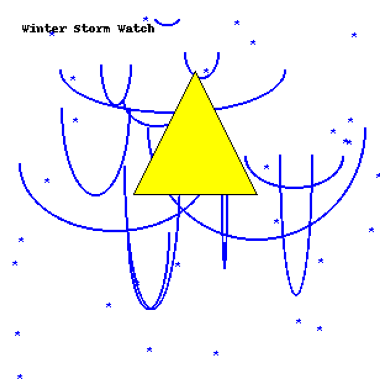

In [147]:
# Ejemplo de uso: obtener la descripción y el evento de una fila en el dataframe
row_index = 75  # Índice numérico de la fila en el dataframe
description = alertas.iloc[row_index]['description']
event = alertas.iloc[row_index]['event']

# Crear el pictograma
create_pictogram(description, event)